# Analyze Experiment Results

In [2]:
import pickle
import os
import sys

# include parent directory in path
parent_dir = os.path.abspath('../..')
sys.path.append(parent_dir)

if os.path.exists('clients.pkl'):
    with open('clients.pkl', 'rb') as file:
        clients = pickle.load(file)
else:
    print('No clients found')


In [3]:
# imports
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import numpy as np
import pandas as pd


In [4]:
# load the metadata

# Initialize an empty dictionary to store the file content
metadata = {}

# Open the file and read line by line
with open('metadata.txt', 'r') as file:
    for line in file:
        # Strip white space and split by colon
        key, value = line.strip().split(': ')
        # Convert numerical values from strings
        if value.replace('.', '', 1).isdigit():
            if '.' in value:
                value = float(value)
            else:
                value = int(value)
        # Add to dictionary
        metadata[key] = value

# Print the dictionary
for key, value in metadata.items():
    print(key, value)


gpu 0
nbr_rounds 100
nbr_clients 100
n_data_train 400
n_data_val 100
seed 1
batch_size 8
nbr_local_epochs 3
lr 3e-05
nbr_classes 10
nbr_channels 3
stopping_rounds 50
nbr_neighbors_sampled 5
prior_update_rule softmax
similarity_metric inverse_training_loss
cosine_alpha 0.5
tau 1
client_information_exchange DAC
experiment_name dev
delusion 0


### Early Stopping

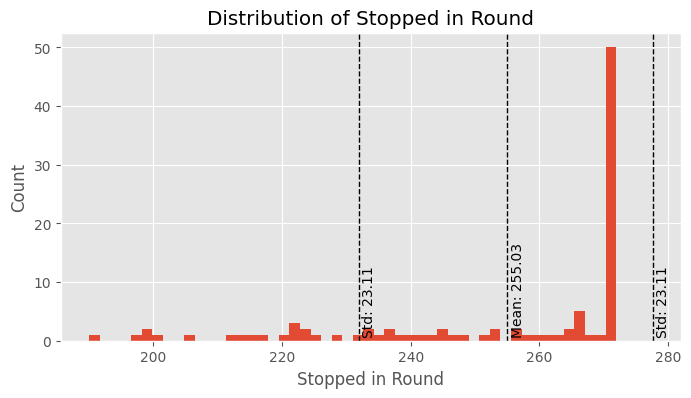

In [5]:
plt.figure(figsize=(8, 4))

stops = []
for client in clients:
    stops.append(len(client.val_acc_list))
plt.hist(stops, bins=50)
plt.xlabel('Stopped in Round')
plt.ylabel('Count')
plt.title('Distribution of Stopped in Round')

# plt mean and standard deviation
mean = np.mean(stops)
std = np.std(stops)
plt.axvline(mean, color='k', linestyle='dashed', linewidth=1)
plt.text(mean + .5, 1, 'Mean: {:.2f}'.format(mean), rotation=90)
plt.axvline(mean + std - .5, color='k', linestyle='dashed', linewidth=1)
plt.text(mean + std, 1, 'Std: {:.2f}'.format(std), rotation=90)
plt.axvline(mean - std, color='k', linestyle='dashed', linewidth=1)
plt.text(mean - std + .5, 1, 'Std: {:.2f}'.format(std), rotation=90)

plt.show()

### Validation Accuracy

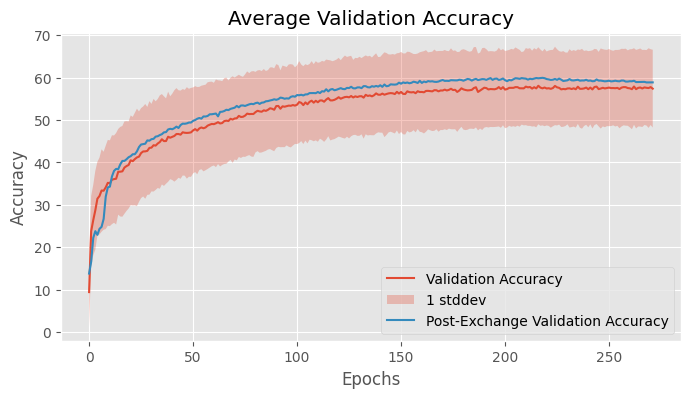

In [6]:
plt.figure(figsize=(8, 4))

# extend val_loss_list for each client to be as long as the longest one
max_len = max([len(client.val_acc_list) for client in clients])
# pad end with last value
for client in clients:
    # shorten val_accs_post_exchange to be the same length as val_acc_list
    if len(client.val_accs_post_exchange) > len(client.val_acc_list):
        client.val_accs_post_exchange = client.val_accs_post_exchange[:len(client.val_acc_list)]
    else:
        client.val_accs_post_exchange.extend([client.val_accs_post_exchange[-1]] * (len(client.val_acc_list) - len(client.val_accs_post_exchange)))
    client.val_acc_list.extend([client.val_acc_list[-1]] * (max_len - len(client.val_acc_list)))
    client.val_accs_post_exchange.extend([client.val_accs_post_exchange[-1]] * (max_len - len(client.val_accs_post_exchange)))

avg_acc = np.mean([client.val_acc_list for client in clients], axis=0)
std_acc = np.std([client.val_acc_list for client in clients], axis=0)
plt.plot(avg_acc)
plt.fill_between(range(len(avg_acc)), avg_acc - std_acc, avg_acc + std_acc, alpha=0.3)

post_exchange_acc = np.mean([client.val_accs_post_exchange for client in clients], axis=0)

plt.plot(post_exchange_acc)

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Average Validation Accuracy')
plt.legend(['Validation Accuracy', '1 stddev','Post-Exchange Validation Accuracy'])


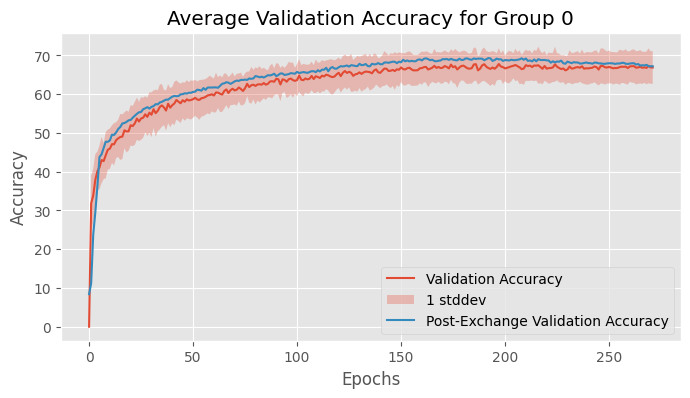

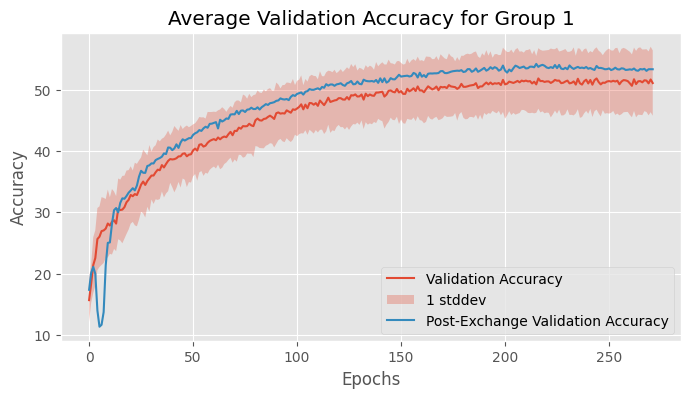

In [8]:
def plot_accuracy_per_group(group):
    plt.figure(figsize=(8, 4))

    avg_acc = np.mean([client.val_acc_list for client in clients if client.group == group], axis=0)
    std_acc = np.std([client.val_acc_list for client in clients if client.group == group], axis=0)
    plt.plot(avg_acc)
    plt.fill_between(range(len(avg_acc)), avg_acc - std_acc, avg_acc + std_acc, alpha=0.3)

    post_exchange_acc = np.mean([client.val_accs_post_exchange for client in clients if client.group == group], axis=0)

    plt.plot(post_exchange_acc)

    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Average Validation Accuracy for Group {}'.format(group))
    plt.legend(['Validation Accuracy', '1 stddev','Post-Exchange Validation Accuracy'])
    plt.show()

# temp 
metadata['dataset'] = 'cifar10'
if metadata['dataset'] == 'cifar10':
    for i in range(2):
        plot_accuracy_per_group(i)
elif metadata['dataset'] == 'PACS':
    for i in range(4):
        plot_accuracy_per_group(i)


### Validation and Training Loss

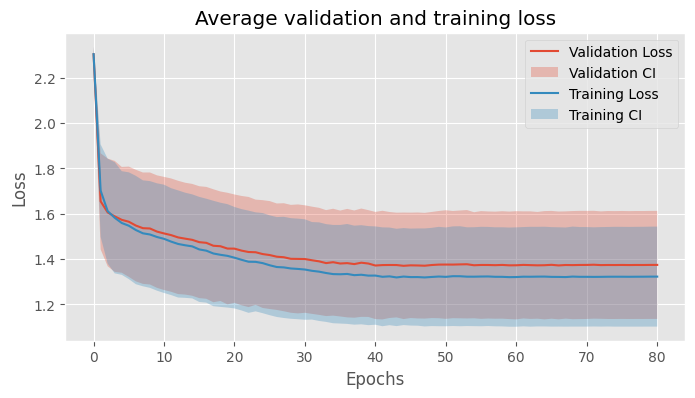

In [ ]:
plt.figure(figsize=(8, 4))

# extend val_loss_list for each client to be as long as the longest one
max_len = max([len(client.val_loss_list) for client in clients])
# pad end with last value
for client in clients:
    client.val_loss_list.extend([client.val_loss_list[-1]] * (max_len - len(client.val_loss_list)))

# extend train_loss_list for each client to be as long as the longest one
max_len = max([len(client.train_loss_list) for client in clients])
# pad end with last value
for client in clients:
    client.train_loss_list.extend([client.train_loss_list[-1]] * (max_len - len(client.train_loss_list)))

avg_val_loss = np.mean([client.val_loss_list for client in clients], axis=0)
std_val_loss = np.std([client.val_loss_list for client in clients], axis=0)
plt.plot(avg_val_loss)
plt.fill_between(range(len(avg_val_loss)), avg_val_loss - std_val_loss, avg_val_loss + std_val_loss, alpha=0.3)
plt.xlabel('Epochs')
plt.ylabel('Loss')

avg_train_loss = np.mean([client.train_loss_list for client in clients], axis=0)
std_train_loss = np.std([client.train_loss_list for client in clients], axis=0)
plt.plot(avg_train_loss)
plt.fill_between(range(len(avg_train_loss)), avg_train_loss - std_train_loss, avg_train_loss + std_train_loss, alpha=0.3)

plt.title('Average validation and training loss')
plt.legend(['Validation Loss', 'Validation CI', 'Training Loss', 'Training CI'])
plt.show()

### Heatmaps

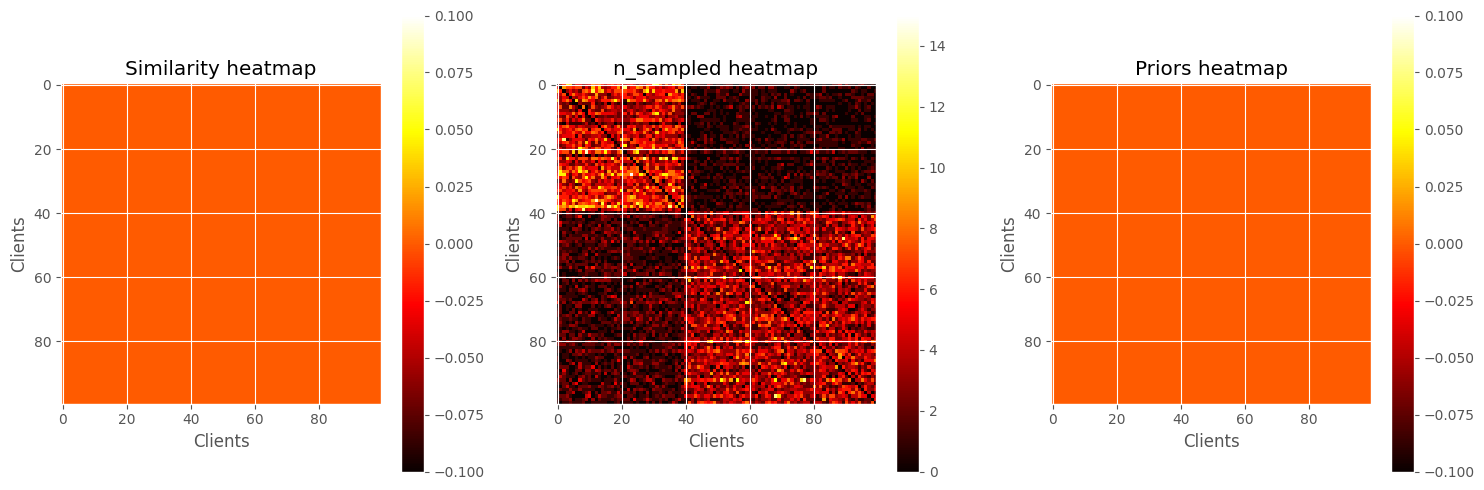

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Similarity heatmap
similarity_matrix = np.zeros((len(clients), len(clients)))
for i, client in enumerate(clients):
    similarity_matrix[i] = client.similarity_scores
im = axes[0].imshow(similarity_matrix, cmap='hot', interpolation='nearest')
axes[0].set_title('Similarity heatmap')
axes[0].set_xlabel('Clients')
axes[0].set_ylabel('Clients')
fig.colorbar(im, ax=axes[0])


# n_sampled heatmap
n_sampled_matrix = np.zeros((len(clients), len(clients)))
for i, client in enumerate(clients):
    n_sampled_matrix[i] = client.n_sampled
im = axes[1].imshow(n_sampled_matrix, cmap='hot', interpolation='nearest')
axes[1].set_title('n_sampled heatmap')
axes[1].set_xlabel('Clients')
axes[1].set_ylabel('Clients')
fig.colorbar(im, ax=axes[1])

# priors heatmap
priors_matrix = np.zeros((len(clients), len(clients)))
for i, client in enumerate(clients):
    priors_matrix[i] = client.priors
im = axes[2].imshow(priors_matrix, cmap='hot', interpolation='nearest')
axes[2].set_title('Priors heatmap')
axes[2].set_xlabel('Clients')
axes[2].set_ylabel('Clients')
fig.colorbar(im, ax=axes[2])

plt.tight_layout()
plt.show()


### Cluster-wise accuracies

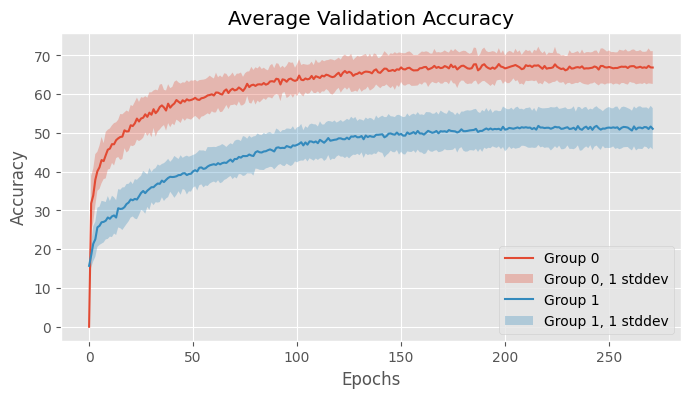

In [9]:
plt.figure(figsize=(8, 4))

nbr_groups = 2 if metadata['dataset'] == 'cifar10' else 4
    
for group in range(2):
    avg_acc = np.mean([client.val_acc_list for client in clients if client.group == group], axis=0)
    std_acc = np.std([client.val_acc_list for client in clients if client.group == group], axis=0)
    plt.plot(avg_acc)
    plt.fill_between(range(len(avg_acc)), avg_acc - std_acc, avg_acc + std_acc, alpha=0.3)
    
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Average Validation Accuracy')
plt.legend(['Group 0', 'Group 0, 1 stddev', 'Group 1', 'Group 1, 1 stddev'])
plt.show()

### Performance on Test Set

In [ ]:
import torchvision.transforms as transforms
from torchvision.datasets import CIFAR10

# Define the transformations
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Load the CIFAR-10 test set
testset = CIFAR10(root='../..', train=False, download=False, transform=transform)



RuntimeError: Dataset not found or corrupted. You can use download=True to download it

In [ ]:
from utils.classes import DatasetSplit
from torch.utils.data import DataLoader

vehicle_idxs = [i for i in range(len(testset)) if testset[i][1] in [0, 1, 8, 9]]
animal_idxs = [i for i in range(len(testset)) if testset[i][1] in [2,3,4,5,6,7]]

# set rot deg to 0 because only label shift is implemented
rot_deg = 0
rot_transform = transforms.RandomRotation(degrees=(rot_deg,rot_deg))
vehicle_set = DatasetSplit(testset,vehicle_idxs,rot_transform)
testloader_vehicle = DataLoader(vehicle_set, batch_size=metadata['batch_size'], shuffle=True)

animal_set = DatasetSplit(testset,animal_idxs,rot_transform)
testloader_animal = DataLoader(animal_set, batch_size=metadata['batch_size'], shuffle=True)

/home/master24/.local/lib/python3.8/site-packages/torch/nn/modules/module.py:1511: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Zero on Zero: 53.10 +/- 1.45
Zero on One: 0.00 +/- 0.00
One on Zero: 0.00 +/- 0.00
One on One: 37.03 +/- 1.28


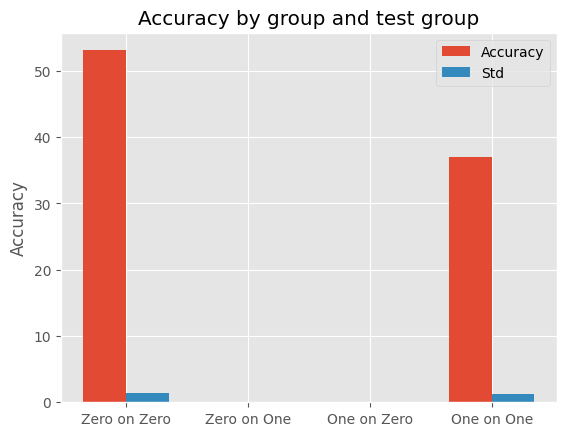

In [ ]:
from utils.testing_utils import test_model

zero_on_zero = []
zero_on_one = []
one_on_zero = []
one_on_one = []

for client in clients:
    acc_v = test_model(client.best_model, testloader_vehicle)
    acc_a = test_model(client.best_model, testloader_animal)
    if client.group == 0:
        zero_on_zero.append(acc_v)
        zero_on_one.append(acc_a)
    else:
        one_on_zero.append(acc_v)
        one_on_one.append(acc_a)

# print mean and std
print('Zero on Zero: {:.2f} +/- {:.2f}'.format(np.mean(zero_on_zero), np.std(zero_on_zero)))
print('Zero on One: {:.2f} +/- {:.2f}'.format(np.mean(zero_on_one), np.std(zero_on_one)))
print('One on Zero: {:.2f} +/- {:.2f}'.format(np.mean(one_on_zero), np.std(one_on_zero)))
print('One on One: {:.2f} +/- {:.2f}'.format(np.mean(one_on_one), np.std(one_on_one)))

# plot barplot of mean and std
fig, ax = plt.subplots()
x = np.arange(4)
width = 0.35
rects1 = ax.bar(x - width/2, [np.mean(zero_on_zero), np.mean(zero_on_one), np.mean(one_on_zero), np.mean(one_on_one)], width, label='Accuracy')
rects2 = ax.bar(x + width/2, [np.std(zero_on_zero), np.std(zero_on_one), np.std(one_on_zero), np.std(one_on_one)], width, label='Std')

ax.set_ylabel('Accuracy')
ax.set_title('Accuracy by group and test group')
ax.set_xticks(x)
ax.set_xticklabels(['Zero on Zero', 'Zero on One', 'One on Zero', 'One on One'])

ax.legend()
plt.show()
